# VIIRs Nighttime Lights Notebook

**Explore S2S Metadata and API**

This notebook walks through an example that uses the API to fetch nighttime lights data for various provinces within a country.

In [1]:
import pandas as pd
import geopandas as gpd
import requests
from shapely import from_geojson
from pystac import Catalog
from typing import Dict, Literal, List, Optional
import matplotlib.pyplot as plt # pip install matplotlib contextily
import contextily as ctx

In [2]:
BASE_URL = "https://space2stats.ds.io"
FIELDS_ENDPOINT = f"{BASE_URL}/fields"
SUMMARY_ENDPOINT = f"{BASE_URL}/summary"
AGGREGATION_ENDPOINT = f"{BASE_URL}/aggregate"
catalog = Catalog.from_file("https://raw.githubusercontent.com/worldbank/DECAT_Space2Stats/refs/heads/main/space2stats_api/src/space2stats_ingest/METADATA/stac/catalog.json")

## Helper Functions

The following python functions are wrappers to help interact with the API.

In [3]:
def get_topics(catalog: Catalog) -> pd.DataFrame:
    """Get a table of items (dataset themes/topics) from the STAC catalog."""
    items = catalog.get_all_items()
    items = list(items)
    topics = [{i.id: {k: v for k, v in i.properties.items() if k in ["name", "description", "source_data"]}} for i in items]
    topics = [pd.DataFrame(t) for t in topics]
    topics = pd.concat(topics, axis=1)
    topics.index.name = "Item ID"
    return topics.transpose()

def get_fields(item_id: str, catalog: Catalog) -> Dict:
    """Get a table with a description of variables for a given dataset (item)."""
    collection = next(catalog.get_collections())
    item = collection.get_item(item_id)
    fields = item.properties["table:columns"]
    return pd.DataFrame(fields)

def fetch_admin_boundaries(iso3: str, adm: str) -> gpd.GeoDataFrame:
    """Fetch administrative boundaries from GeoBoundaries API."""
    url = f"https://www.geoboundaries.org/api/current/gbOpen/{iso3}/{adm}/"
    res = requests.get(url).json()
    cShapes = gpd.read_file(res["gjDownloadURL"])
    cShapes['geometry'] = cShapes['geometry'].buffer(0)

    return(cShapes)

def get_summary(
        gdf: gpd.GeoDataFrame, 
        spatial_join_method: Literal["touches", "centroid", "within"], 
        fields: List[str], 
        geometry: Optional[Literal["polygon", "point"]] = None
        ) -> pd.DataFrame:
    """Extract h3 level data from Space2Stats for a GeoDataFrame.

    Parameters
    ----------
    gdf : GeoDataFrame
        The Areas of Interest

    spatial_join_method : ["touches", "centroid", "within"]
        The method to use for performing the spatial join between the AOI and H3 cells
            - "touches": Includes H3 cells that touch the AOI
            - "centroid": Includes H3 cells where the centroid falls within the AOI
            - "within": Includes H3 cells entirely within the AOI

    fields : List[str]
        A list of field names to retrieve from the statistics table.

    geometry : Optional["polygon", "point"]
        Specifies if the H3 geometries should be included in the response. It can be either "polygon" or "point". If None, geometries are not included

    Returns
    -------
    DataFrame
        A DataFrame with the requested fields for each H3 cell that intersects with the AOIs.
    """
    res_all = {}
    for idx, row in gdf.iterrows():
        request_payload = {
            "aoi": {
                "type": "Feature",
                "geometry": row.geometry.__geo_interface__,
                "properties": {},
            },
            "spatial_join_method": spatial_join_method,
            "fields": fields,
            "geometry": geometry,
        }
        response = requests.post(SUMMARY_ENDPOINT, json=request_payload)

        if response.status_code != 200:
            raise Exception(f"Failed to get summary: {response.text}")
        
        summary_data = response.json()
        if not summary_data:
            print(f"Failed to get summary for {idx}")
            summary_data = pd.DataFrame()  # Return an empty DataFrame if no data

        df = pd.DataFrame(summary_data)
        res_all[idx] = df
    
    res_all = pd.concat(res_all, names=["index_gdf", "index_h3"])
    res_all = res_all.reset_index()
    gdf_copy = gdf.copy()
    gdf_copy.drop(columns=["geometry"], inplace=True)
    res_all = gdf_copy.merge(res_all, left_index=True, right_on="index_gdf")
    return res_all

def get_aggregate(
        gdf: gpd.GeoDataFrame, 
        spatial_join_method: Literal["touches", "centroid", "within"],
        fields: list, 
        aggregation_type: Literal["sum", "avg", "count", "max", "min"]
    ) -> pd.DataFrame:
    """Extract summary statistic from underlying H3 Space2Stats data.

    Parameters
    ----------
    gdf : GeoDataFrame
        The Areas of Interest

    spatial_join_method : ["touches", "centroid", "within"]
        The method to use for performing the spatial join between the AOI and H3 cells
            - "touches": Includes H3 cells that touch the AOI
            - "centroid": Includes H3 cells where the centroid falls within the AOI
            - "within": Includes H3 cells entirely within the AOI

    fields : List[str]
        A list of field names to retrieve from the statistics table.

    aggregation_type : ["sum", "avg", "count", "max", "min"]
        Statistical function to apply to each field per AOI.

    Returns
    -------
    DataFrame
        A DataFrame with the requested fields for each H3 cell that intersects with the AOIs.
    
    """
    res_all = []
    for idx, row in gdf.iterrows():
        request_payload = {
            "aoi": {
                "type": "Feature",
                "geometry": row.geometry.__geo_interface__,
                "properties": {},
            },
            "spatial_join_method": spatial_join_method,
            "fields": fields,
            "aggregation_type": aggregation_type,
        }
        response = requests.post(AGGREGATION_ENDPOINT, json=request_payload)

        if response.status_code != 200:
            raise Exception(f"Failed to get aggregate: {response.text}")
        
        aggregate_data = response.json()
        if not aggregate_data:
            print(f"Failed to get summary for {idx}")
            aggregate_data = pd.DataFrame()  # Return an empty DataFrame if no data

        df = pd.DataFrame(aggregate_data, index=[idx])
        res_all.append(df)
    
    res_all = pd.concat(res_all)
    gdf_copy = gdf.copy()
    res_all = gdf_copy.join(res_all)
    return res_all

In [5]:
response = requests.get(FIELDS_ENDPOINT)
if response.status_code != 200:
    raise Exception(f"Failed to get fields: {response.text}")

ntl_fields = [x for x in response.json() if 'viirs' in x]
print("Available Fields:", ntl_fields)

Available Fields: ['sum_viirs_ntl_2024', 'sum_viirs_ntl_2012', 'sum_viirs_ntl_2013', 'sum_viirs_ntl_2014', 'sum_viirs_ntl_2015', 'sum_viirs_ntl_2016', 'sum_viirs_ntl_2017', 'sum_viirs_ntl_2018', 'sum_viirs_ntl_2019', 'sum_viirs_ntl_2020', 'sum_viirs_ntl_2021', 'sum_viirs_ntl_2022', 'sum_viirs_ntl_2023']


## Extract H3 Data

Let's work with the subset of fields from the flood exposure item: `['pop', 'pop_flood', 'pop_flood_pct']`

We will define our AOIs by fetching admin boundaries from the GeoBoundaries project.

<Axes: >

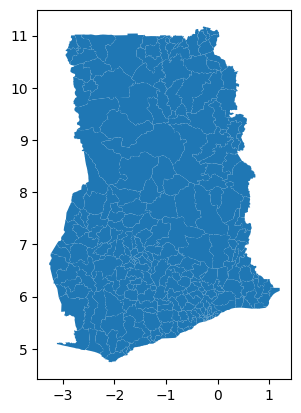

In [18]:
ISO3 = "GHA" # Sri Lanka 
ADM = "ADM2" # Level 2 administrative boundaries
adm_boundaries = fetch_admin_boundaries(ISO3, ADM)
adm_boundaries.plot()

Run API Calls

In [19]:
df = get_summary(
    gdf=adm_boundaries, 
    spatial_join_method="centroid", 
    fields=ntl_fields,
    geometry="polygon"
)

Failed to get summary for 171
Failed to get summary for 209
Failed to get summary for 211
Failed to get summary for 214
Failed to get summary for 216
Failed to get summary for 223
Failed to get summary for 224


In [20]:
pd.reset_option('display.max_colwidth')
df.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,sum_viirs_ntl_2024,...,sum_viirs_ntl_2014,sum_viirs_ntl_2015,sum_viirs_ntl_2016,sum_viirs_ntl_2017,sum_viirs_ntl_2018,sum_viirs_ntl_2019,sum_viirs_ntl_2020,sum_viirs_ntl_2021,sum_viirs_ntl_2022,sum_viirs_ntl_2023
0,Adenta Municipal,,2480657B26321648161032,GHA,ADM2,0,0,8675292c7ffffff,"{""type"":""Polygon"",""coordinates"":[[[-0.15240489...",6169.789551,...,2567.030273,2216.290039,3093.850098,3011.320068,3435.450195,3931.380371,4644.580078,5707.790039,6385.500000,6864.250000
1,Adenta Municipal,,2480657B26321648161032,GHA,ADM2,0,1,8675292f7ffffff,"{""type"":""Polygon"",""coordinates"":[[[-0.17012096...",4950.759766,...,1757.910034,1739.000000,2213.620117,2376.550049,2776.479980,3560.209961,3859.500000,4675.529785,5283.129883,5423.979980
2,Ledzokuku Municipal,,2480657B94892111901595,GHA,ADM2,1,0,8675292cfffffff,"{""type"":""Polygon"",""coordinates"":[[[-0.13470130...",5792.570312,...,3516.310059,2612.379883,3395.709961,3264.790039,3668.920166,4090.350098,4804.399902,5679.729980,6269.459961,6652.089844
3,Chereponi,,2480657B14989848452061,GHA,ADM2,2,0,8658b4967ffffff,"{""type"":""Polygon"",""coordinates"":[[[0.094141931...",623.640015,...,215.689987,48.549999,128.250000,363.279999,54.639999,56.500000,79.260002,95.729996,78.589996,135.169998
4,Chereponi,,2480657B14989848452061,GHA,ADM2,2,1,8658b496fffffff,"{""type"":""Polygon"",""coordinates"":[[[0.146993959...",61.050003,...,160.029999,170.580002,142.860001,341.379974,102.029999,63.560001,74.510002,64.690002,92.099998,99.300003


Check that there are no duplicate hexagon ids

In [21]:
df['hex_id'].duplicated().sum()

0

Convert geometry column from geojson into shapely polygons

In [22]:
df["geometry"] = df["geometry"].apply(lambda geom: from_geojson(geom))
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,sum_viirs_ntl_2024,...,sum_viirs_ntl_2014,sum_viirs_ntl_2015,sum_viirs_ntl_2016,sum_viirs_ntl_2017,sum_viirs_ntl_2018,sum_viirs_ntl_2019,sum_viirs_ntl_2020,sum_viirs_ntl_2021,sum_viirs_ntl_2022,sum_viirs_ntl_2023
0,Adenta Municipal,,2480657B26321648161032,GHA,ADM2,0,0,8675292c7ffffff,"POLYGON ((-0.1524 5.69181, -0.15745 5.66442, -...",6169.789551,...,2567.030273,2216.290039,3093.850098,3011.320068,3435.450195,3931.380371,4644.580078,5707.790039,6385.500000,6864.250000
1,Adenta Municipal,,2480657B26321648161032,GHA,ADM2,0,1,8675292f7ffffff,"POLYGON ((-0.17012 5.74101, -0.17516 5.7136, -...",4950.759766,...,1757.910034,1739.000000,2213.620117,2376.550049,2776.479980,3560.209961,3859.500000,4675.529785,5283.129883,5423.979980
2,Ledzokuku Municipal,,2480657B94892111901595,GHA,ADM2,1,0,8675292cfffffff,"POLYGON ((-0.1347 5.64264, -0.13975 5.61527, -...",5792.570312,...,3516.310059,2612.379883,3395.709961,3264.790039,3668.920166,4090.350098,4804.399902,5679.729980,6269.459961,6652.089844
3,Chereponi,,2480657B14989848452061,GHA,ADM2,2,0,8658b4967ffffff,"POLYGON ((0.09414 10.02528, 0.0888 9.99592, 0....",623.640015,...,215.689987,48.549999,128.250000,363.279999,54.639999,56.500000,79.260002,95.729996,78.589996,135.169998
4,Chereponi,,2480657B14989848452061,GHA,ADM2,2,1,8658b496fffffff,"POLYGON ((0.14699 10.0096, 0.14163 9.98024, 0....",61.050003,...,160.029999,170.580002,142.860001,341.379974,102.029999,63.560001,74.510002,64.690002,92.099998,99.300003


Map hexagon data

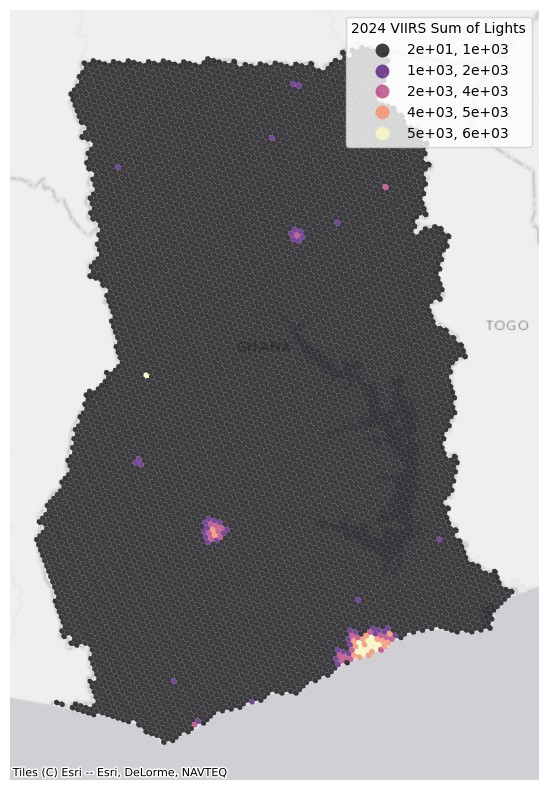

In [23]:
gdf.loc[:, "VIIRS_change"] = (gdf["sum_viirs_ntl_2023"] - gdf["sum_viirs_ntl_2013"]) / gdf["sum_viirs_ntl_2013"]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, column="sum_viirs_ntl_2024", 
         legend=True, cmap="magma", alpha=0.75, 
         scheme="equal_interval", k=5, 
         legend_kwds=dict(title='2024 VIIRS Sum of Lights', fmt="{:.0}"),
         linewidth=0)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas, crs='EPSG:4326')
plt.axis("off")
plt.show()

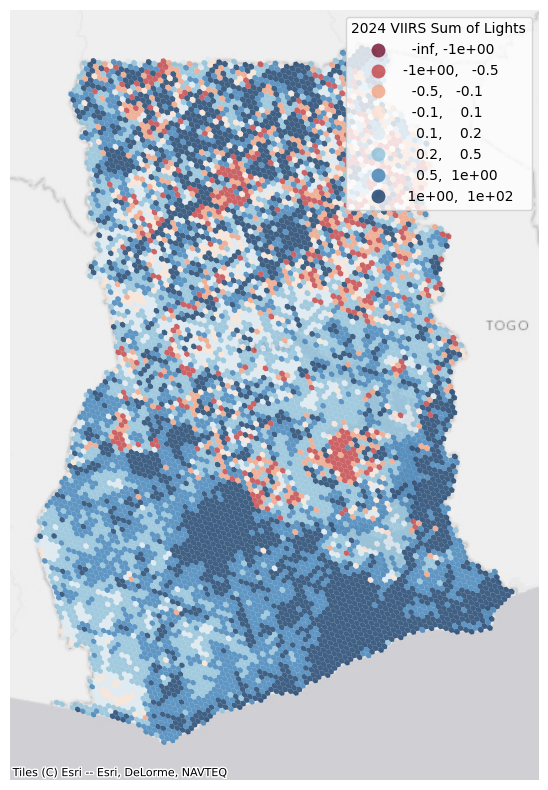

In [27]:
# Plot NTL change
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, column="VIIRS_change", 
         legend=True, cmap="RdBu", alpha=0.75, 
         scheme='UserDefined', 
         classification_kwds={'bins': [-1, -.5, -.1, .1, .25, 0.5, 1, 100]}, 
         legend_kwds=dict(title='VIIRS change 2013 to 2023', fmt="{:.0}"),
         linewidth=0)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas, crs='EPSG:4326')
plt.axis("off")
plt.show()

## Extract Admin Summaries

In [12]:
adm_boundaries_zs = get_aggregate(
    gdf=adm_boundaries, 
    spatial_join_method="centroid", 
    fields=['sum_viirs_ntl_2023', 'sum_viirs_ntl_2013'], 
    aggregation_type="sum"
)

In [13]:
adm_boundaries_zs.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry,sum_viirs_ntl_2023,sum_viirs_ntl_2013
0,Jaffna District,LK-41,46371173B9817749849456,LKA,ADM2,"MULTIPOLYGON (((80.62159 9.45951, 80.61353 9.4...",6333.860046,3541.249996
1,Kilinochchi District,LK-42,46371173B45994965995152,LKA,ADM2,"MULTIPOLYGON (((80.25498 9.6146, 80.25702 9.61...",4391.070045,2639.069958
2,Mannar District,LK-43,46371173B85619240954295,LKA,ADM2,"MULTIPOLYGON (((80.11535 9.20907, 80.11708 9.2...",6016.450027,3779.019936
3,Mullaitivu District,LK-45,46371173B72468588006826,LKA,ADM2,"POLYGON ((80.61353 9.45658, 80.62159 9.45951, ...",8014.119980,4977.789948
4,Vavuniya District,LK-44,46371173B6040081493503,LKA,ADM2,"POLYGON ((80.23541 8.68041, 80.23489 8.68217, ...",6463.449944,4879.740059


Calculate change in nighttime lights brightness from 2013 to 2023

In [15]:
adm_boundaries_zs.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry,sum_viirs_ntl_2023,sum_viirs_ntl_2013,VIIRS_change
0,Jaffna District,LK-41,46371173B9817749849456,LKA,ADM2,"MULTIPOLYGON (((80.62159 9.45951, 80.61353 9.4...",6333.860046,3541.249996,0.788594
1,Kilinochchi District,LK-42,46371173B45994965995152,LKA,ADM2,"MULTIPOLYGON (((80.25498 9.6146, 80.25702 9.61...",4391.070045,2639.069958,0.663870
2,Mannar District,LK-43,46371173B85619240954295,LKA,ADM2,"MULTIPOLYGON (((80.11535 9.20907, 80.11708 9.2...",6016.450027,3779.019936,0.592066
3,Mullaitivu District,LK-45,46371173B72468588006826,LKA,ADM2,"POLYGON ((80.61353 9.45658, 80.62159 9.45951, ...",8014.119980,4977.789948,0.609976
4,Vavuniya District,LK-44,46371173B6040081493503,LKA,ADM2,"POLYGON ((80.23541 8.68041, 80.23489 8.68217, ...",6463.449944,4879.740059,0.324548


In [17]:
adm_boundaries_zs["VIIRS_change"].min()

0.10198351448570035

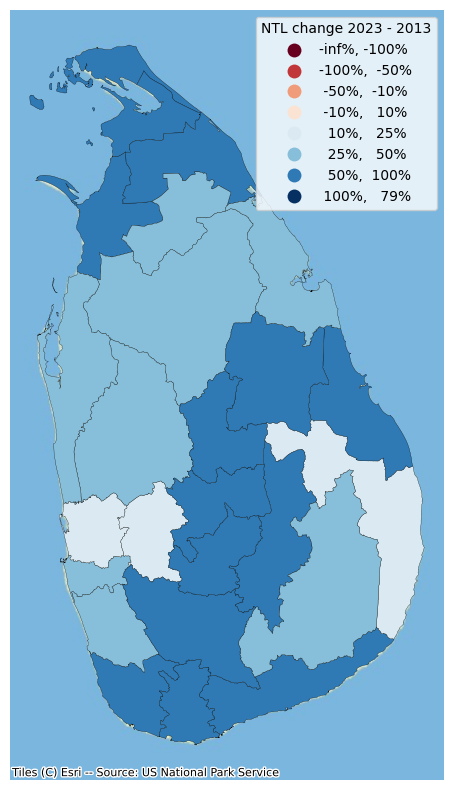

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adm_boundaries_zs.plot(
    ax=ax, column="VIIRS_change", legend=True, 
    cmap="RdBu", scheme='UserDefined', 
         classification_kwds={'bins': [-1, -.5, -.1, .1, .25, 0.5, 1, max(adm_boundaries_zs["VIIRS_change"])]},
    k=5, legend_kwds=dict(title='NTL change 2023 - 2013', fmt="{:.0%}"),
    linewidth=0.2, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldPhysical, crs='EPSG:4326')
plt.axis("off")
plt.show()

List bottom 20 counties by VIIRS change

In [ ]:
table = adm_boundaries_zs.sort_values('VIIRS_change', ascending=False).tail(20)[['shapeName', 'VIIRS_change', 'sum_viirs_ntl_2023', 'sum_viirs_ntl_2013']].rename(
    columns={
        'shapeName': 'Province',
        'sum_viirs_ntl_2023':'VIIRS 2023', 
        'sum_viirs_ntl_2013':'VIIRS 2013'
        })
#table.loc[:, "Population Exposed"] = table.loc[:, "pop_flood"].apply(lambda x: f"{x:,.0f}")
#table.loc[:, "Population Exposed (%)"] = table.loc[:, "pop_flood_pct"].apply(lambda x: f"{x:.2%}")
table.reset_index(drop=True, inplace=True)
display(table[['Province', 'VIIRS_change','VIIRS 2023', 'VIIRS 2013']])